# Misael Morales
## 3D Reservoir Inversion via Deep Learning
***

In [1]:
# Load base packages
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import pyvista as pv

# Load my project packages
from utils_3d import *

# restart keras
keras.backend.clear_session()

In [2]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [3]:
### Load individual datasets from simulations
# satu, pres, poro, perm, facies, prod, timestamps = make_initial_data()
satu, pres, poro, perm, facies, prod, timestamps = load_initial_data()

Pres: (318, 40, 48, 48, 8) | Satu: (318, 40, 48, 48, 8)
Poro: (318, 48, 48, 8) | Perm: (318, 48, 48, 8) | Facies: (318, 48, 48, 8)
Timestamps: (40,) | Production: (318, 40, 9, 4)


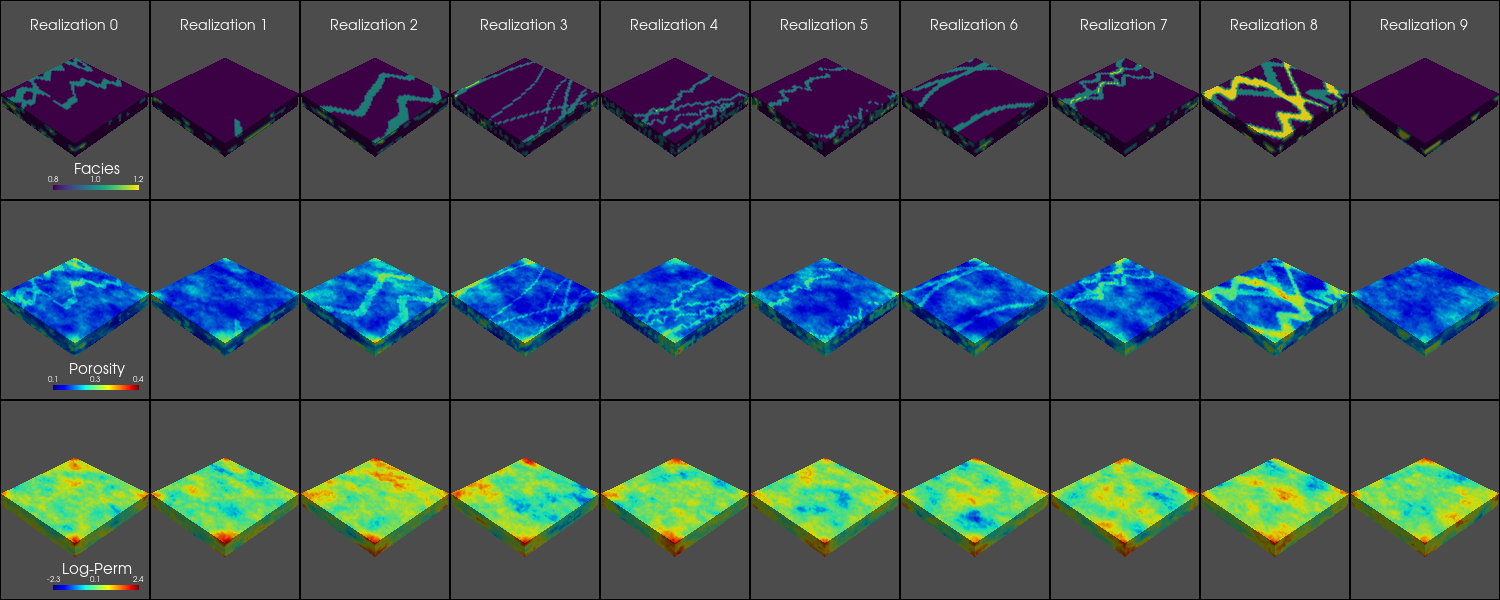

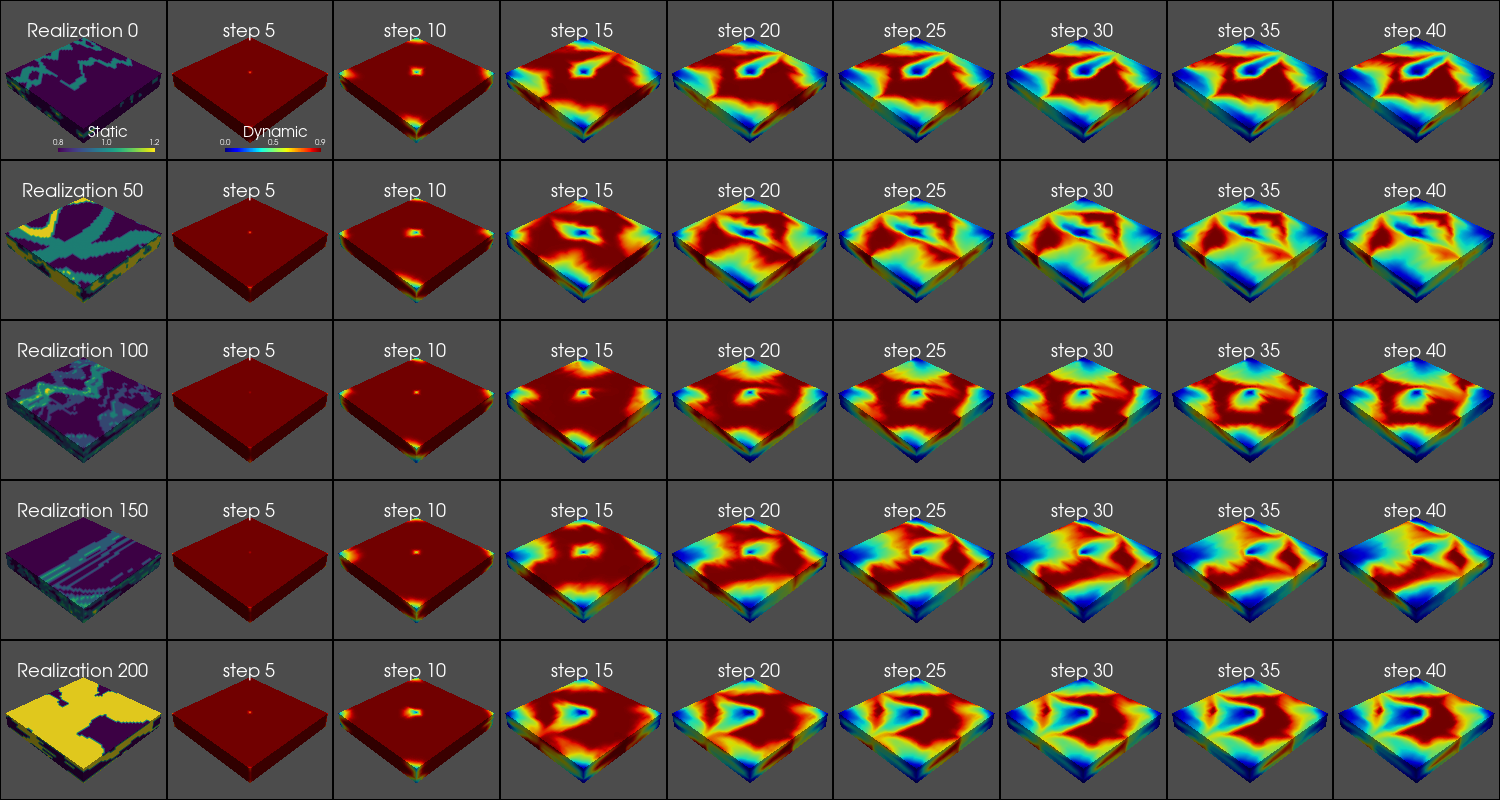

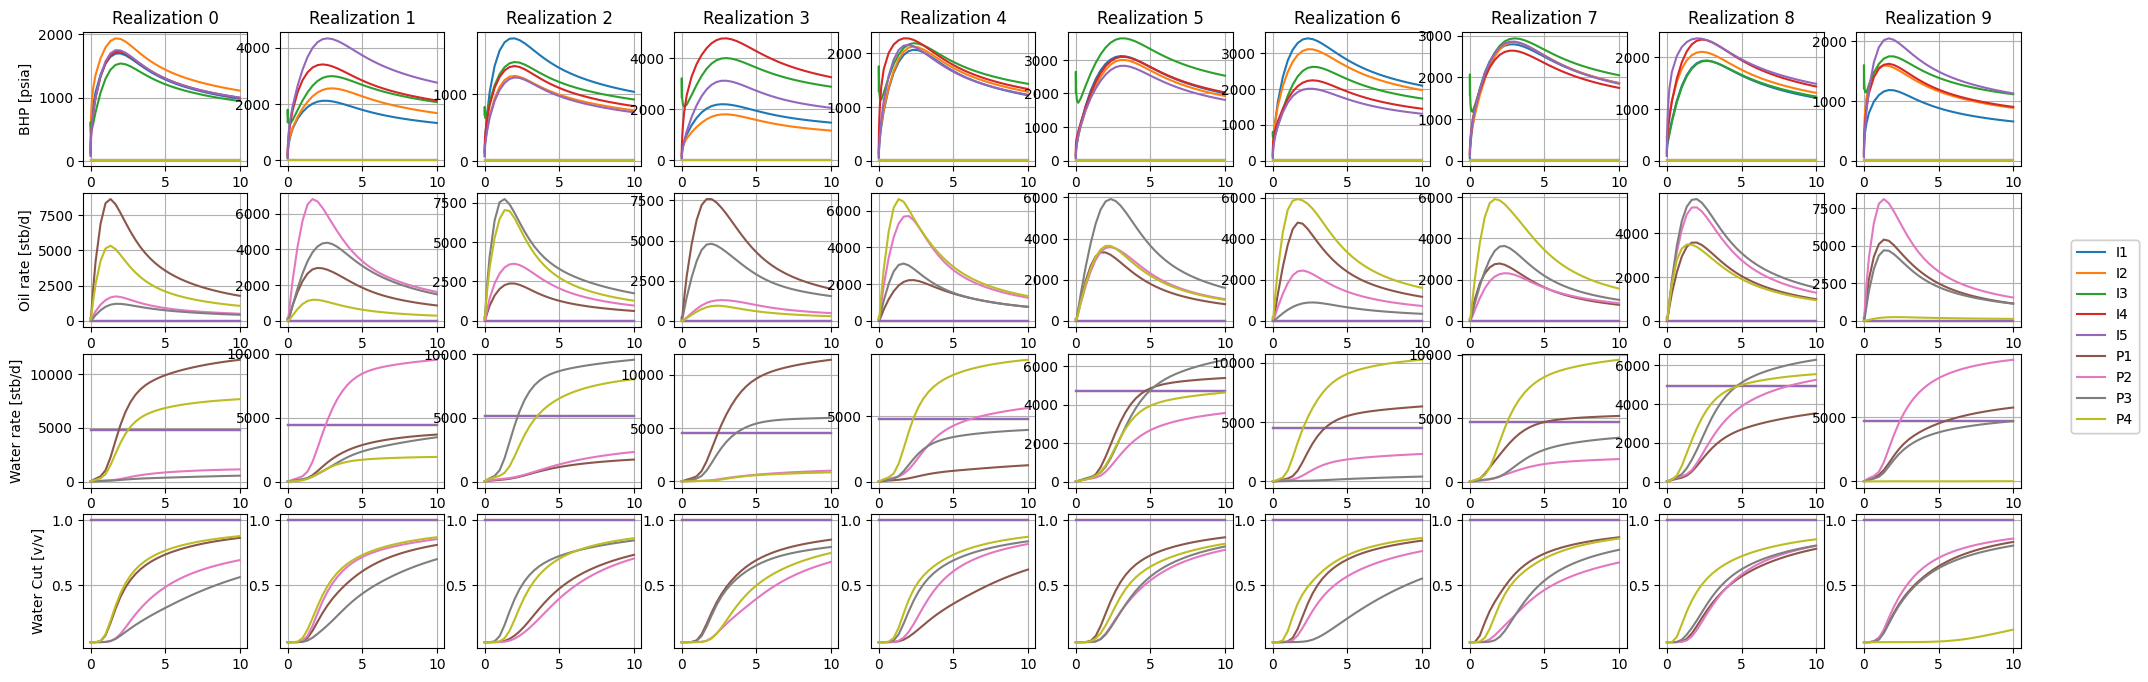

In [5]:
plot_static(facies, poro, perm)
plot_dynamic(facies, satu, multiplier=50)
plot_data(timestamps, prod)

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [6]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data, t_data = split_xywt(facies, poro, perm, pres, satu, prod, timestamps, save=True)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (318, 40, 48, 48, 8, 2) | y shape: (318, 48, 48, 8, 3) | w shape: (318, 40, 9, 4)
t shape: (40,)


In [7]:
# Perform train-test split
X_train, X_test, y_train, y_test, w_train, w_test, idxs, randxy = my_train_test_split(X_data, y_data, w_data)

X_train shape: (2000, 40, 30, 2) | X_test shape: (544, 40, 30, 2)
w_train shape: (2000, 40, 9, 4)  | w_test shape: (544, 40, 9, 4)
y_train shape: (2000, 48, 48, 3) | y_test shape: (544, 48, 48, 3)


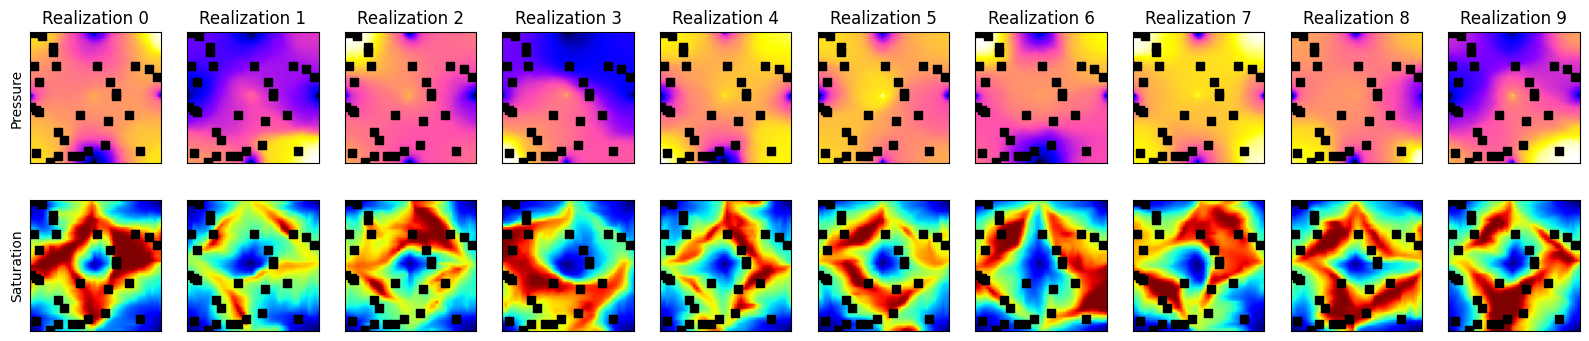

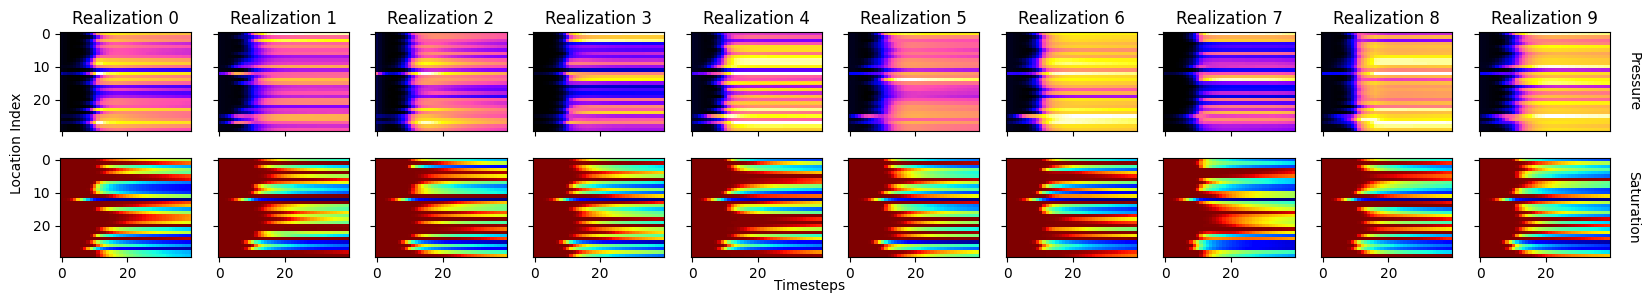

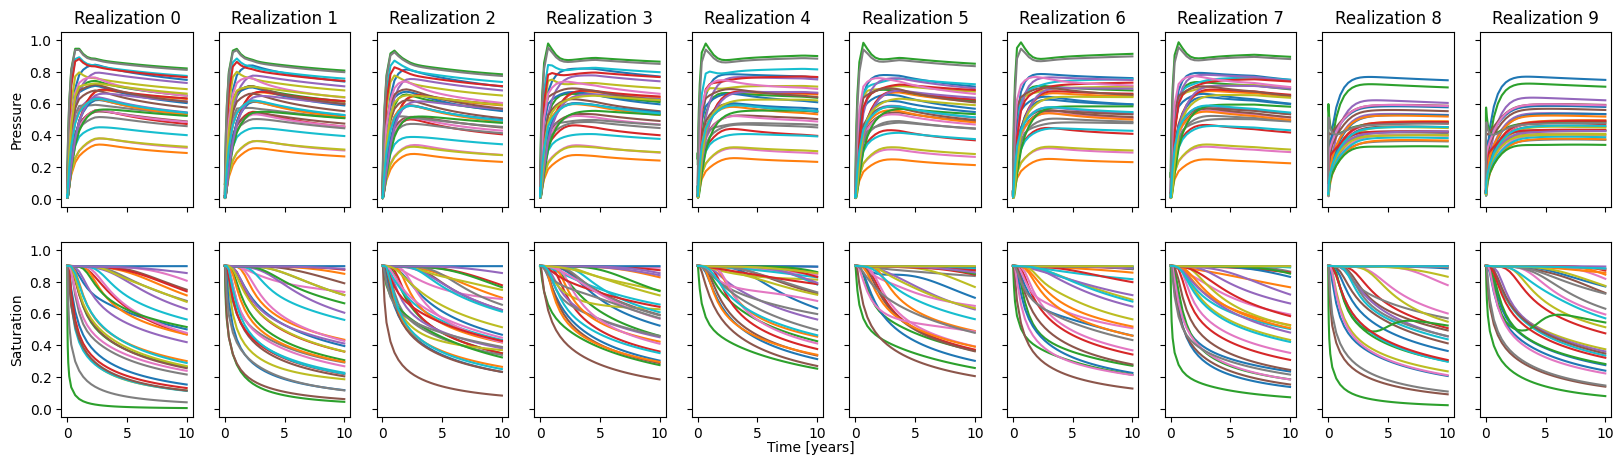

In [8]:
# Visualize X-samples
plot_X_img_observations(X_data, randxy)
plot_X_observations(X_train)
plot_X_line_observations(X_train, timestamps)

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

# Parameters: 930,060 | Training time: 0.47 minutes
# Parameters: 11,694 | Training time: 8.82 minutes
# Parameters: 5,021,640 | Training time: 0.86 minutes


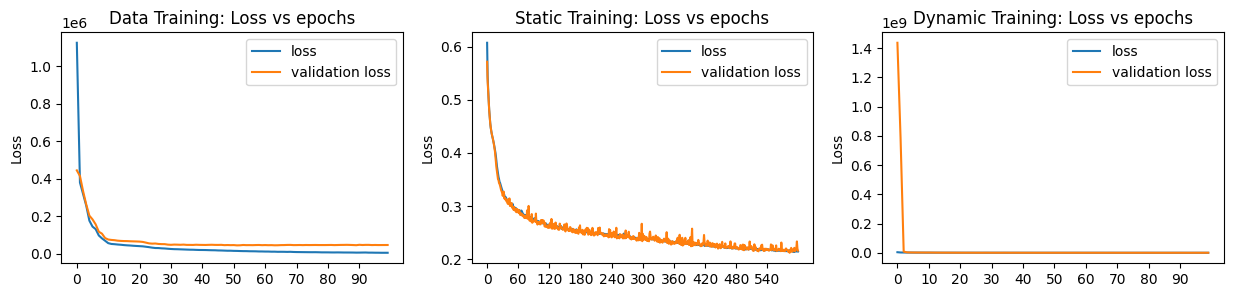

In [9]:
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
plot_loss_all(data_fit, static_fit, dynamic_fit)

17/17 [==============================] - 0s 4ms/step
Train MSE: 5.21e-04 | Test MSE: 5.21e-04
Train SSIM: 99.46 | Test SSIM: 98.19


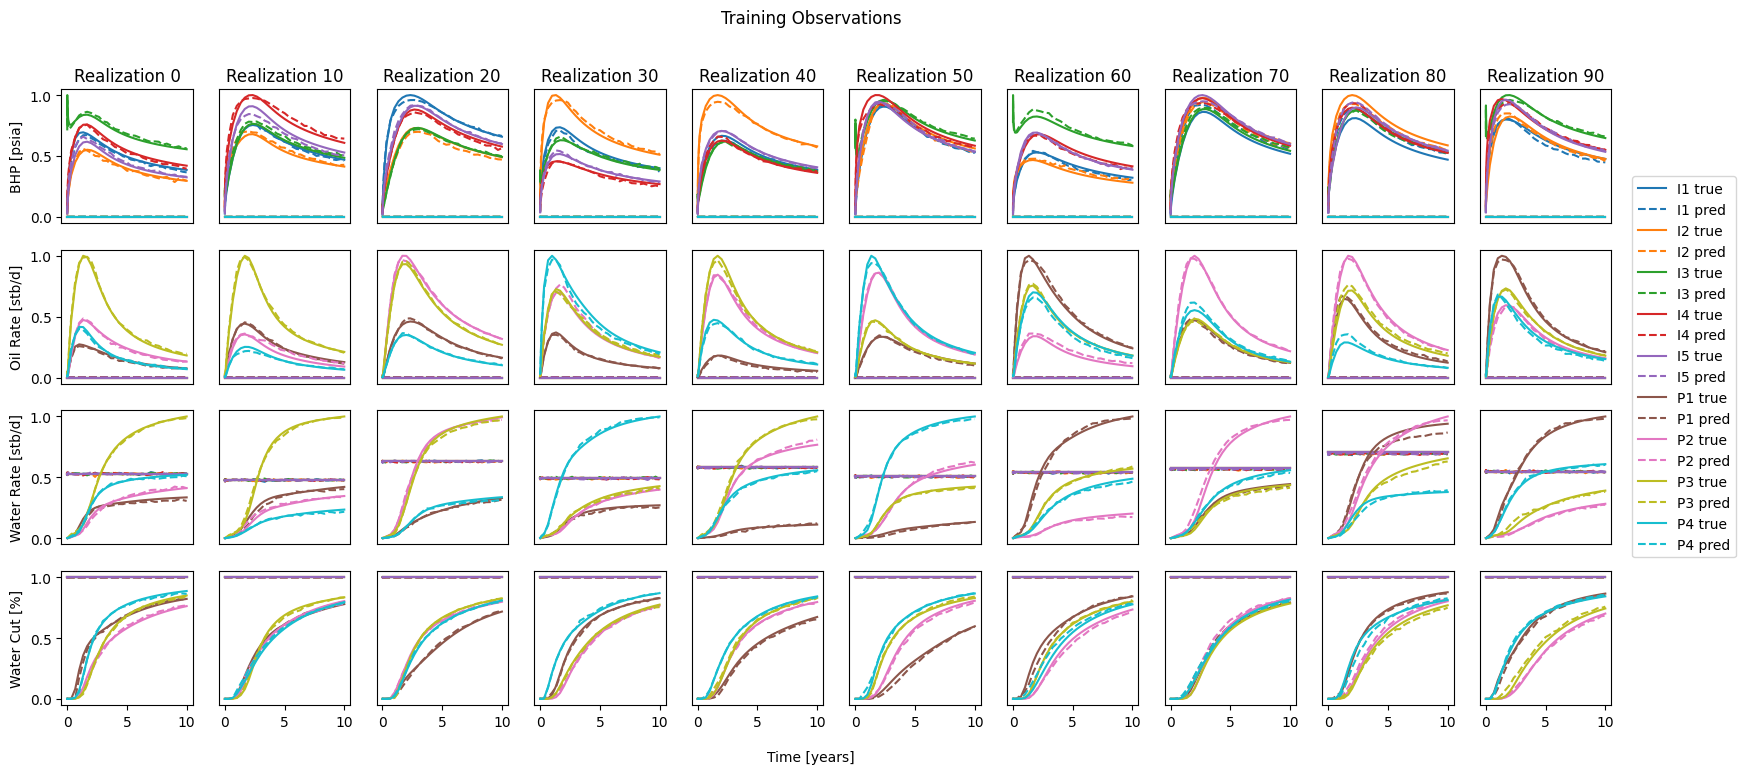

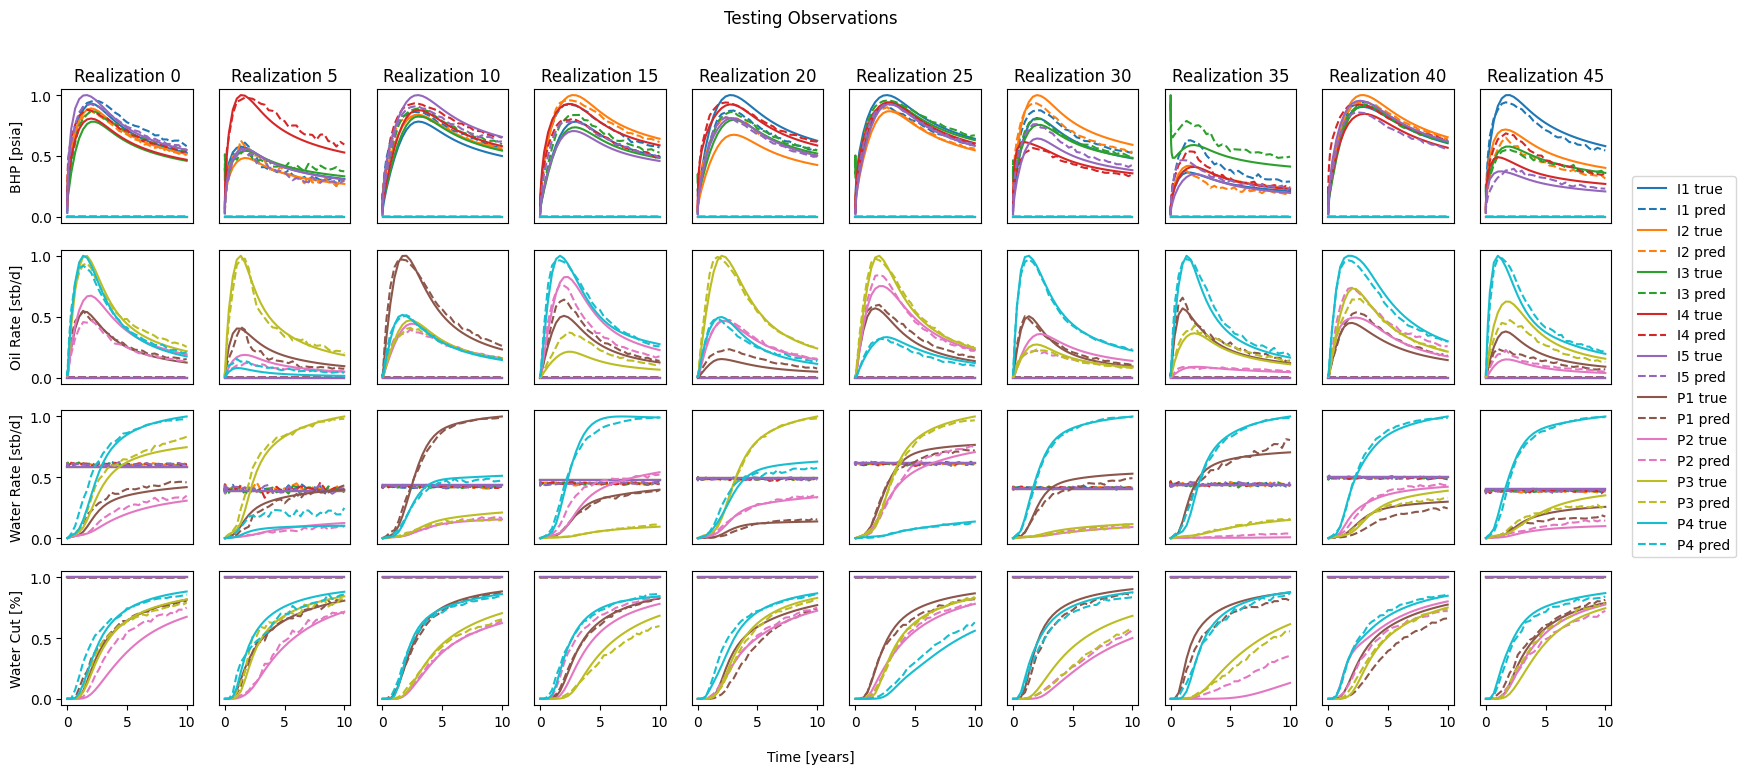

In [10]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_train_pred, multiplier=10, suptitle='Training')
plot_data_results(timestamps, w_test,  w_test_pred,  multiplier=5,  suptitle='Testing')

17/17 [==============================] - 0s 9ms/step
Train MSE: 2.08e-02 | Test MSE: 2.08e-02
Train SSIM: 82.63 | Test SSIM: 81.59


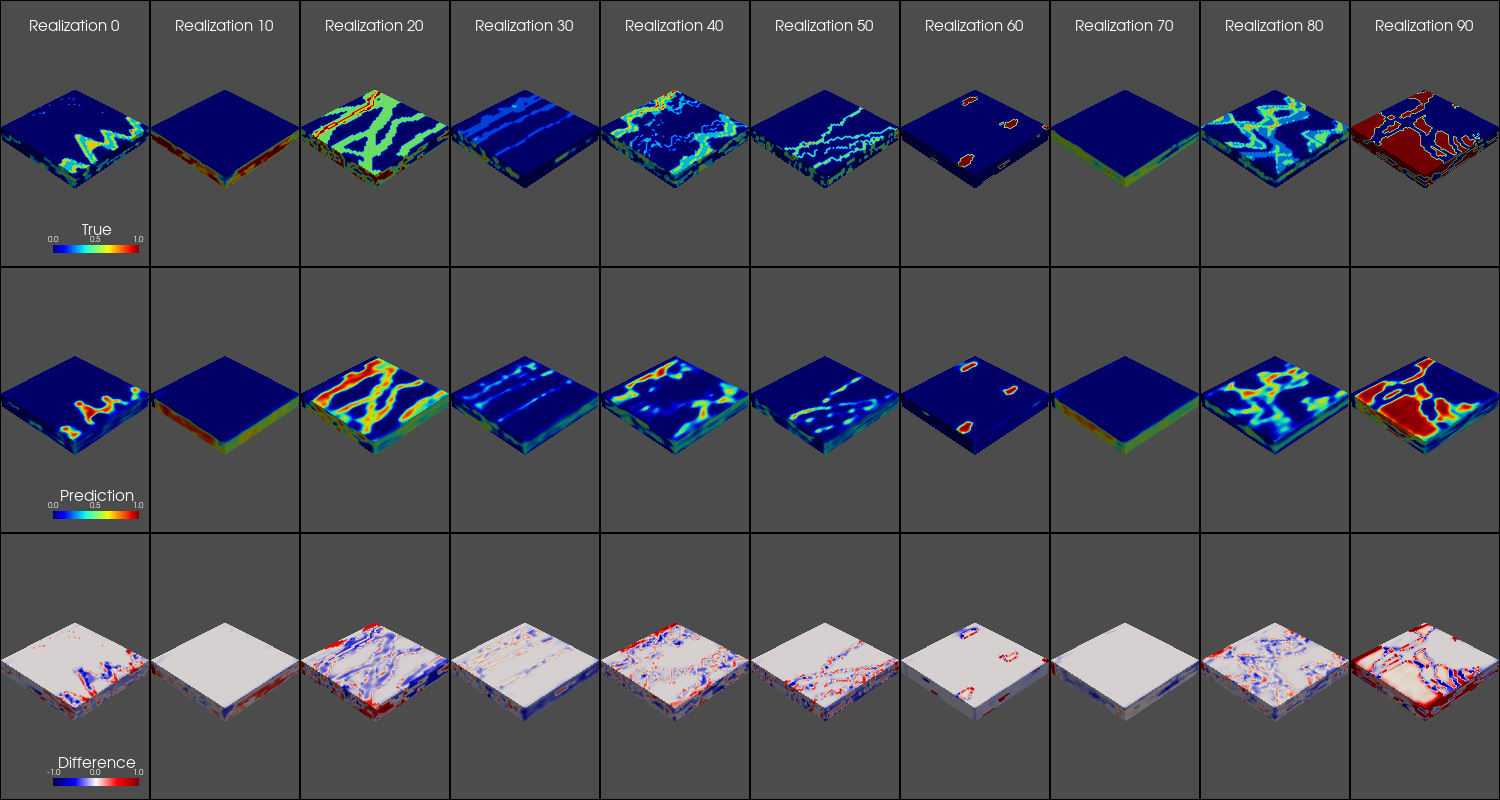

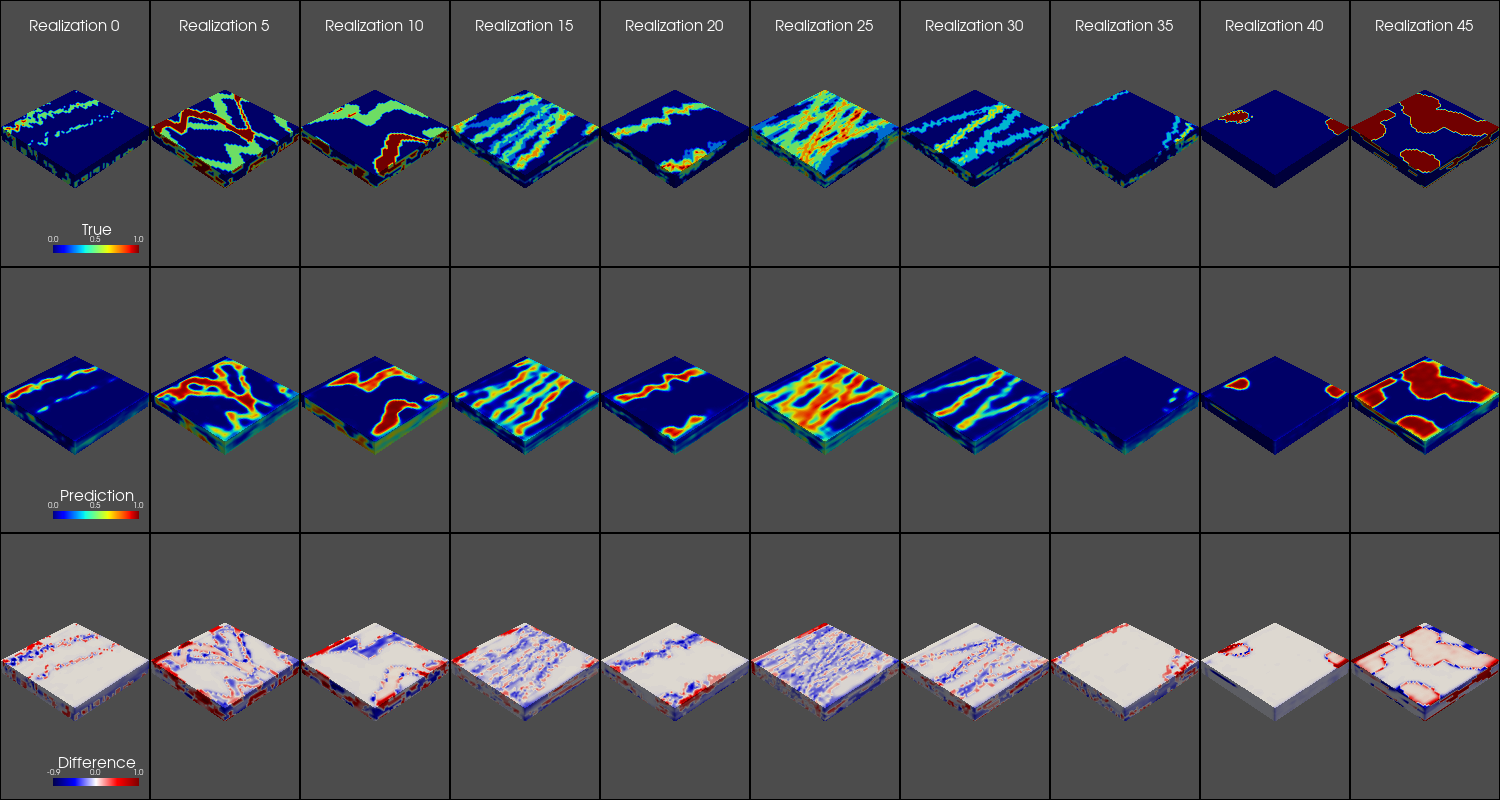

In [11]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results(y_train, y_train_pred, channel_select=0, multiplier=10)
plot_static_results(y_test, y_test_pred, channel_select=0, multiplier=5)

17/17 [==============================] - 0s 3ms/step
Train MSE: 3.20e-03 | Test MSE: 3.20e-03
Train SSIM: 94.86 | Test SSIM: 92.55


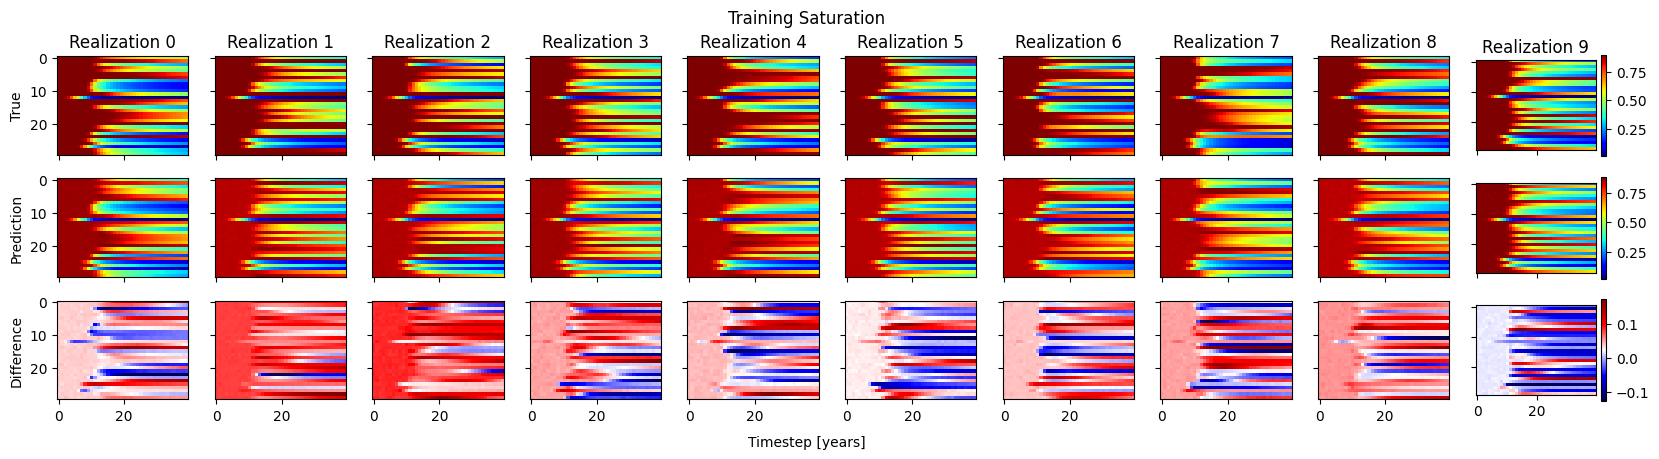

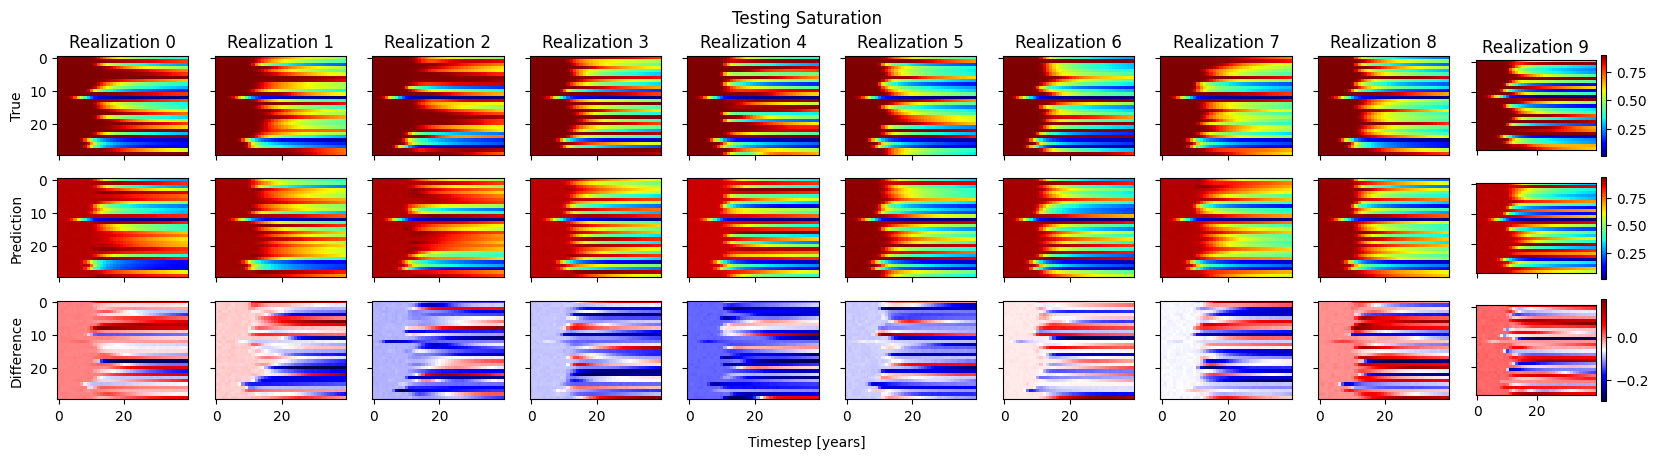

In [12]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results(X_train, X_train_pred, channel_select=1, suptitle='Training')
plot_dynamic_results(X_test, X_test_pred, channel_select=1, suptitle='Testing')

***
# Build, Compile, Train, and Predict with Latent-Inversion Network

In [13]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (2544, 40, 30, 2) | w_full: (2544, 40, 9, 4) | y_full: (2544, 48, 48, 3)


# Parameters: 33,438,571 | Training time: 8.53 minutes


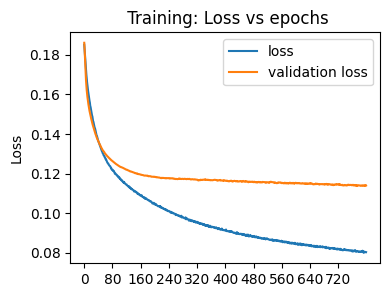

In [14]:
reg, reg_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(reg_fit, figsize=(4,3))

In [ ]:
temp1 = np.moveaxis(np.concatenate([y_train[...,0], y_test[...,0]]).reshape(318,8,48,48),1,-1)

In [ ]:
newfacies = np.concatenate([np.take(facies, idxs[0], axis=0), np.take(facies, idxs[1], axis=0)])

In [ ]:
p = pv.Plotter(shape=(3,10))
for j in range(10):
    p.subplot(0,j)
    p.add_mesh(np.flip(temp1[j]), cmap='viridis', scalar_bar_args={'title':'truth'})
    p.subplot(1,j)
    p.add_mesh(np.flip(facies[j]), cmap='viridis', scalar_bar_args={'title':'Train'})
    p.subplot(2,j)
    p.add_mesh(np.flip(newfacies[j]), cmap='viridis', scalar_bar_args={'title':'Original'})

p.show(jupyter_backend='static',window_size=(1000,300))

In [ ]:
inv_train, inv_test = make_inv_prediction(reg, [X_train, X_test], [w_train, w_test], [y_train, y_test])
plot_static_results(y_train, inv_train, multiplier=15, channel_select=0, cmaps=['viridis','gray_r'])
plot_static_results(y_test,  inv_test,  multiplier=2,  channel_select=0, cmaps=['viridis','gray_r'])

***
# Back-Normalize inversion results to original domain and visualize

In [ ]:
train_idx

In [ ]:
facies_hat, poro_hat, perm_hat = make_inv_backnorm([inv_train, inv_test], [facies, poro, perm])
plot_static(facies_hat, poro_hat, perm_hat, multiplier=10, cmaps=['viridis','jet','jet'])

***
# END